In this post, we're going to dab a little bit in machine learning and face recognition to predict if an image from a live webcam shows a smiling subject or not. 
First, we will use an existing dataset, called the ["Olivetti faces dataset"](http://scikit-learn.org/stable/datasets/olivetti_faces.html) and classify the 400 faces seen there in one of two categories: smiling or not smiling. Then, we train a [support vector classifier](http://en.wikipedia.org/wiki/Support_vector_machine) on this dataset to predict if a face depicts a smiling person or not. We do this by using the awesome [sklearn](http://scikit-learn.org/stable/) machine learning library for Python. Finally, we integrate this classifier into a live loop using [OpenCV](http://opencv.org) to capture a frame from our webcam, extract a face and annotate the image with the result of the machine learning prediction.

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("mc3XGJaDEMc")

Please note that I use Python 2.7 in this post due to OpenCV incompatibility issues on my system with Python 3.

# Part 1: training a classifier on the existing `faces` dataset

## Loading the `faces` dataset

We load the dataset using standard `sklearn` functions below.

In [5]:
%matplotlib inline
from pylab import *

In [6]:
from sklearn import datasets

In [7]:
faces = datasets.fetch_olivetti_faces()

The `faces` dataset consist of 400 images depicting 40 subjects in a variety of poses: open and closed eyes, smiling or not. The data can be accessed trough the keys below:

In [8]:
faces.keys()

['images', 'data', 'target', 'DESCR']

One can plot a selection of images from the dataset.

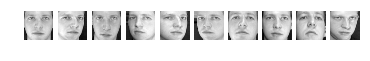

In [9]:
for i in range(10):
    face = faces.images[i]
    subplot(1, 10, i + 1)
    imshow(face.reshape((64, 64)), cmap='gray')
    axis('off')

## Producing the smile training data

Now that the dataset is loaded, we will build a cheap user interface to classify the 400 images into two categories:

- smiling face
- not smiling face

The class below stores the outcome of the user classification as a dictionary and is used to display the next image upon pressing a button from the GUI.

In [10]:
from IPython.html.widgets import interact, ButtonWidget
from IPython.display import display, clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [11]:
class Trainer:
    def __init__(self):
        self.results = {}
        self.imgs = faces.images
        self.index = 0
        
    def increment_face(self):
        if self.index + 1 >= len(self.imgs):
            return self.index
        else:
            while str(self.index) in self.results:
                print self.index
                self.index += 1
            return self.index
    
    def record_result(self, smile=True):
        self.results[str(self.index)] = smile

We first instantiate the class and then design a user interface using two buttons from the awesome `IPython.html.widgets` tools.

In [12]:
trainer = Trainer()

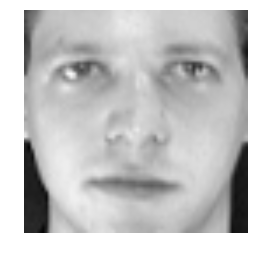

In [13]:
button_smile = ButtonWidget(description='smile')
button_no_smile = ButtonWidget(description='sad face')

def display_face(face):
    clear_output()
    imshow(face, cmap='gray')
    axis('off')

def update_smile(b):
    trainer.record_result(smile=True)
    trainer.increment_face()
    display_face(trainer.imgs[trainer.index])

def update_no_smile(b):
    trainer.record_result(smile=False)
    trainer.increment_face()
    display_face(trainer.imgs[trainer.index])

button_no_smile.on_click(update_no_smile)
button_smile.on_click(update_smile)

display(button_smile)
display(button_no_smile)
display_face(trainer.imgs[trainer.index])

## Saving and loading the temporary results from the classification

Due to the fact that I classified the 400 faces over two sessions, I had to save the temporary results and reload them. This (and loading) is done in the lines below.

### Loading training dataset

In [14]:
import pickle

In [15]:
results = pickle.load(open( "./data/results.p", "rb" ) )
trainer.results = results

In [16]:
print len(results)
print len(trainer.results)

400
400


In [17]:
# import json

In [18]:
# results = json.load(open('results.xml'))

In [19]:
# trainer.results = results

### Saving training dataset

In [20]:
# pickle.dump( trainer.results, open( "./data/results.p", "wb" ) )

In [21]:
#with open('results.xml', 'w') as f:
#    json.dump(trainer.results, f)

## Visualizing the training set data

Now that our input data is ready, we can plot a little statistic from our dataset: how many people are smiling in the pictures and how many are not?

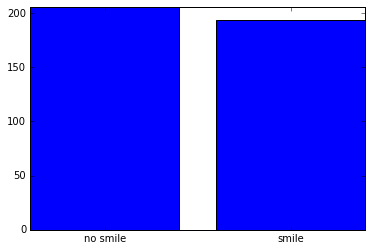

In [22]:
yes, no = (sum([trainer.results[x] == True for x in trainer.results]), 
            sum([trainer.results[x] == False for x in trainer.results]))
bar([0, 1], [no, yes])
ylim(0, max(yes, no))
xticks([0.4, 1.4], ['no smile', 'smile']);

Below, we're displaying the images of all the smiles and all the "non smiles" that we have classified.

In [23]:
smiling_indices = [int(i) for i in results if results[i] == True]

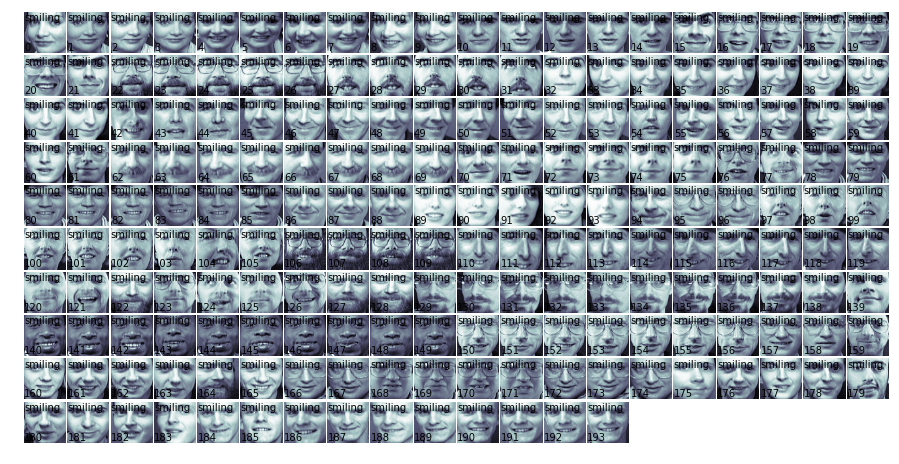

In [24]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[smiling_indices[i]], cmap=plt.cm.bone)
    
    # label the image with the target value
    p.text(0, 14, "smiling")
    p.text(0, 60, str(i))
    p.axis('off')

As you can see, some of the faces classified as smiling could be disagreed with. In fact, I often found myself confused while doing this task, because some of the images cannot be easily put into a smiling or non-smiling category in my opinion.

In [28]:
not_smiling_indices = [int(i) for i in results if results[i] == False]

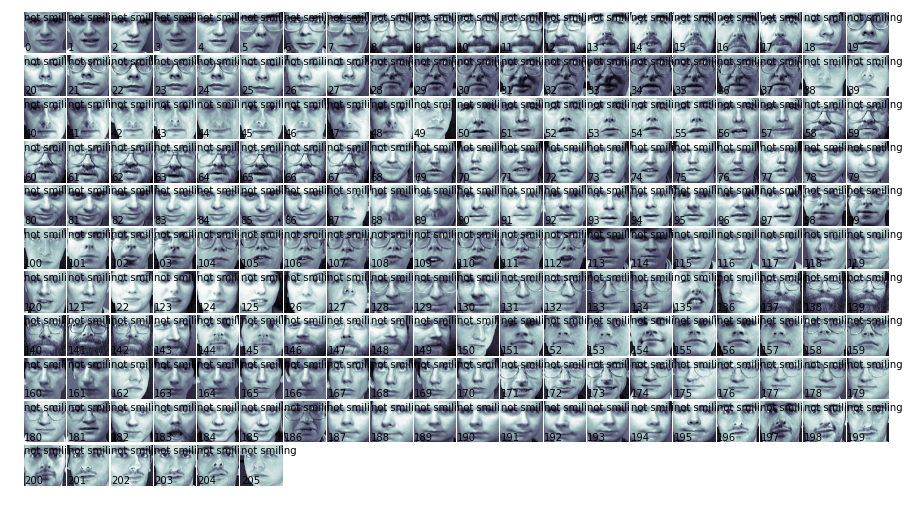

In [26]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(not_smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[not_smiling_indices[i]], cmap=plt.cm.bone)

    # label the image with the target value
    p.text(0, 14, "not smiling")
    p.text(0, 60, str(i))
    p.axis('off')

## Training the smile classifier

Now that we have our input data, we can train a machine learning model with it. I was inspired by the [following ressource while writing my code](http://nbviewer.ipython.org/github/gmonce/scikit-learn-book/blob/master/Chapter%202%20-%20Supervised%20Learning%20-%20Image%20Recognition%20with%20Support%20Vector%20Machines.ipynb). 

In the following, we use a support vector classifier to learn from the 400 smiles and non-smiles and predict the classification of a new image. 

First, we initialize the classifier with:

In [27]:
from sklearn.svm import SVC
svc_1 = SVC(kernel='linear')

We then build our dataset. First comes the image data:

In [29]:
indices = [i for i in trainer.results]
data = faces.data[indices, :]

/Users/zhecanwang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  from IPython.kernel.zmq import kernelapp as app


Then comes the target vector (in which a 1 stands for a smile and a 0 for a "non smile").

In [30]:
target = [trainer.results[i] for i in trainer.results]
target = array(target).astype(int32)

Finally, we train the classifier using 5 fold cross validation. I will not go into the details of this as I am not yet familiar enough with the subject.

In [31]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=0.25, random_state=0)

In [32]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

The trained classifier's performance is then evaluated:

In [33]:
evaluate_cross_validation(svc_1, X_train, y_train, 5)

[ 0.78333333  0.78333333  0.83333333  0.83333333  0.83333333]
Mean score: 0.813 (+/-0.012)


A mean score of approximately 0.8 is quite good. A further statistic is the confusion matrix that shows the errors that the classifier made during training.

In [34]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Classification Report:")
    print (metrics.classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))

In [35]:
train_and_evaluate(svc_1, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.75
Classification Report:
             precision    recall  f1-score   support

          0       0.64      0.82      0.72        39
          1       0.86      0.70      0.77        61

avg / total       0.77      0.75      0.75       100

Confusion Matrix:
[[32  7]
 [18 43]]


## Testing the classifier on the training data

To check that our the trained machine learning classifier works, we again build a "cheap" GUI for displaying a face as well as the classifier prediction for this face.

this person is smiling: [False]


/Users/zhecanwang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


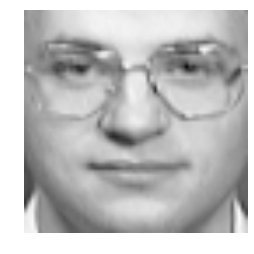

In [36]:
random_image_button = ButtonWidget(description="New image!")

def display_face_and_prediction(b):
    index = randint(0, 400)
    face = faces.images[index]
    display_face(face)
    print("this person is smiling: {0}".format(svc_1.predict(faces.data[index, :])==1))

random_image_button.on_click(display_face_and_prediction)
display(random_image_button)
display_face_and_prediction(0)

As I am now convinced that this works reasonably well, we can now move on to the second part of this post: using OpenCV to capture an input and predict if the person is smiling or not.

In [37]:
from sklearn.externals import joblib
# joblib.dump(svc_1, './data/faceDetectSVC.pkl') 
# svc_1 = joblib.load('faceDetectSVC.pkl') 


# Part 2: face recognition and prediction using openCV

## Offline face recognition and smile prediction

In this section, we set up our algorithm to do the following things using still images of my face capture with the webcam (hence the name "offline"): 

- face detection on a supplied input image
- extraction of features from within the detected face; these features should have the same size than the ones that we used during the training of the SVC classifier above (i.e. 64x64 gray scale images)
- predicting if the detected person is smiling using the previously trained classifier

First, we import `cv2` and a test image.

In [60]:
import cv2

ImportError: No module named cv2

In [68]:
input_face = cv2.imread('face6.jpg')

NameError: name 'cv2' is not defined

Next, we use a [Haar cascade](http://docs.opencv.org/trunk/doc/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect a face in the input image. An XML file containing the cascade is read as an input for this.

In [31]:
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
gray = cv2.cvtColor(input_face, cv2.COLOR_BGR2GRAY)
detected_faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(100, 100),
        flags=cv2.cv.CV_HAAR_SCALE_IMAGE
    )
detected_faces

array([[386, 134, 290, 290]], dtype=int32)

A single faces was recognized. It is displayed with the original picture below:

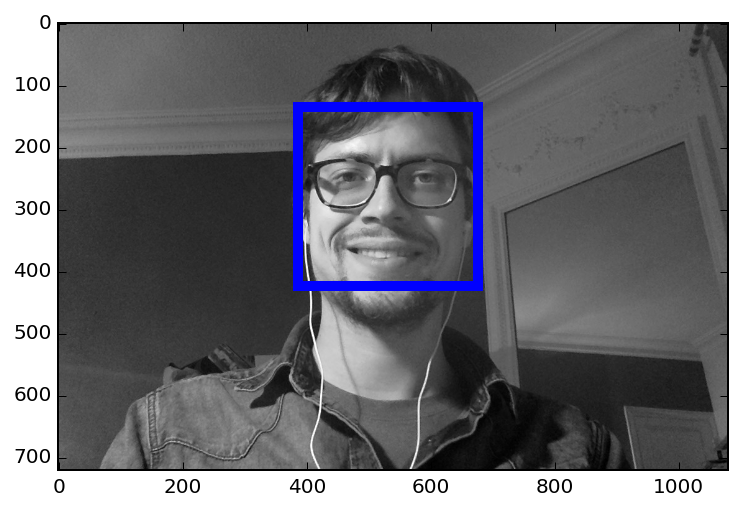

In [32]:
from matplotlib.patches import Rectangle
ax = gca()
ax.imshow(gray, cmap='gray')
for (x, y, w, h) in detected_faces:
    ax.add_artist(Rectangle((x, y), w, h, fill=False, lw=5, color='blue'))

We can now extract features from the face detected above to feed them to the SVC classifier. We do a little bit of stretching and cropping with arbitrarily set values to match the approximate format of the faces from the Olivetti dataset used to train the classifier.

In [33]:
original_extracted_face = gray[y:y+h, x:x+w]
horizontal_offset = 0.15 * w
vertical_offset = 0.2 * h
extracted_face = gray[y+vertical_offset:y+h, 
                      x+horizontal_offset:x-horizontal_offset+w]

We can compare the extracted feature with the original face region returned by the Haar cascade.

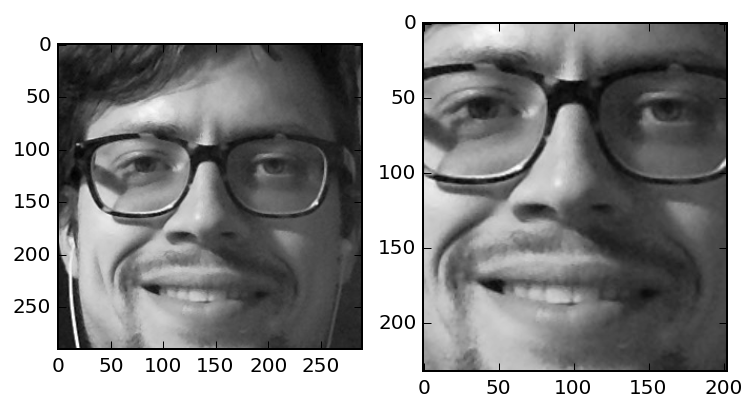

In [34]:
subplot(121)
imshow(original_extracted_face, cmap='gray')
subplot(122)
imshow(extracted_face, cmap='gray')

Finally, we transform the extracted image, that is approximately 200 times 200 pixels to a 64 times 64 image, so that it matches the feature format of the Olivetti dataset faces.

In [35]:
from scipy.ndimage import zoom

In [36]:
new_extracted_face = zoom(extracted_face, (64. / extracted_face.shape[0], 
                                           64. / extracted_face.shape[1]))

In [37]:
new_extracted_face = new_extracted_face.astype(float32)

In [38]:
new_extracted_face /= float(new_extracted_face.max())

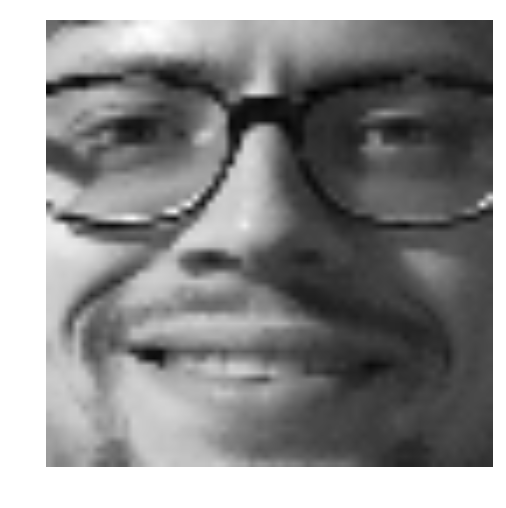

In [39]:
display_face(new_extracted_face[:, :])

As you can see, my face has been a little stretched. Let's see if our classifier predicts that I'm smiling:

In [1]:
svc_1.predict(new_extracted_face.ravel())

NameError: name 'svc_1' is not defined

It worked (because a 1 means a smile)! 

We can also check that the prediction step is very fast:

In [43]:
%timeit svc_1.predict(new_extracted_face.ravel())

1000 loops, best of 3: 837 µs per loop


Let's now write functions that automate the steps described above so that we can use them in a loop during live detection.

First, we rewrite the code for face detection. It uses a frame from the camera as input, converts it to grayscale and applies the Haar cascade to it. The detected faces and the gray images are then returned by the function.

In [40]:
def detect_face(frame):
    cascPath = "./data/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=6,
            minSize=(100, 100),
            flags=cv2.cv.CV_HAAR_SCALE_IMAGE
        )
    return gray, detected_faces

Next, we write a function that extract features from a previously detected face in a gray image (hence its inputs). It also takes as arguments the horizontal and vertical stretch factors used to extract features for our classifier. Later on, we will decide on how to choose those coefficients using something else than luck.

In [41]:
def extract_face_features(gray, detected_face, offset_coefficients):
    (x, y, w, h) = detected_face
    horizontal_offset = offset_coefficients[0] * w
    vertical_offset = offset_coefficients[1] * h
    extracted_face = gray[y+vertical_offset:y+h, 
                      x+horizontal_offset:x-horizontal_offset+w]
    new_extracted_face = zoom(extracted_face, (64. / extracted_face.shape[0], 
                                           64. / extracted_face.shape[1]))
    new_extracted_face = new_extracted_face.astype(float32)
    new_extracted_face /= float(new_extracted_face.max())
    return new_extracted_face

Finally, we define a function that predicts if an extracted face is smiling or not. This is basically just a wrapper call to the `predict` function of our SVC.

In [42]:
def predict_face_is_smiling(extracted_face):
    return svc_1.predict(extracted_face.ravel())

I've taken two photographs of my face to test the algorithm. On the first one, I'm not smiling. On the second, I am. Let's see if our algorithm works well with these two faces.

NameError: name 'cv2' is not defined

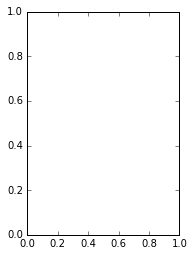

In [43]:
subplot(121)
imshow(cv2.cvtColor(cv2.imread('face5.jpg'), cv2.COLOR_BGR2GRAY), cmap='gray')
subplot(122)
imshow(cv2.cvtColor(cv2.imread('face6.jpg'), cv2.COLOR_BGR2GRAY), cmap='gray')

We now have to choose which offset coefficients, which are used to scale the capture face to the one fed to the classifier, are best for our problem. To make this choice a little more easy, we will plot the outcome of the SVC for different stretching coefficients in an interactive manner:

In [48]:
gray1, face1 = detect_face(cv2.imread("face5.jpg"))
gray2, face2 = detect_face(cv2.imread("face6.jpg"))

In [49]:
def test_recognition(c1, c2):
    subplot(121)
    extracted_face1 = extract_face_features(gray1, face1[0], (c1, c2))
    imshow(extracted_face1, cmap='gray')
    print(predict_face_is_smiling(extracted_face1))
    subplot(122)
    extracted_face2 = extract_face_features(gray2, face2[0], (c1, c2))
    imshow(extracted_face2, cmap='gray')
    print(predict_face_is_smiling(extracted_face2))

[0]
[1]


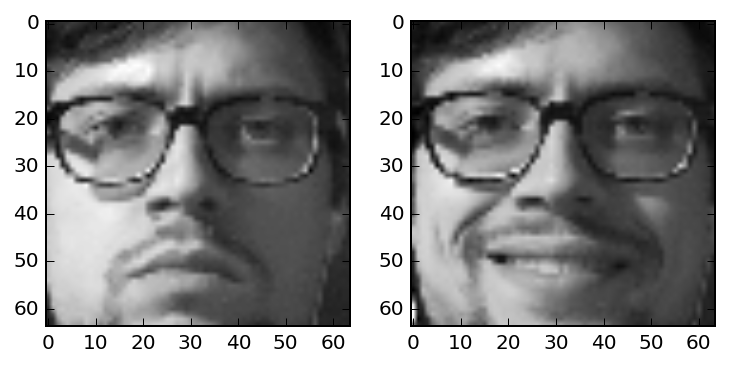

In [50]:
interact(test_recognition,
         c1=(0.0, 0.3, 0.01),
         c2=(0.0, 0.3, 0.01))

By playing a little bit with the settings, it's possible to get a result that's opposite of the one we expect. This is problematic as it means the classifier heavily depends on the stretching coefficients applied to the image from the webcam. To setup things in a way that's a little less arbitrary, I will build a map of the output (i.e. smile or not smile) over a range of different values for the two stretching parameters.

In [38]:
def make_map(facefile):
    c1_range = linspace(0, 0.35)
    c2_range = linspace(0, 0.3)
    result_matrix = nan * zeros_like(c1_range * c2_range[:, newaxis])
    gray, detected_faces = detect_face(cv2.imread(facefile))
    for face in detected_faces[:1]:
        for ind1, c1 in enumerate(c1_range):
            for ind2, c2 in enumerate(c2_range):
                extracted_face = extract_face_features(gray, face, (c1, c2))
                result_matrix[ind1, ind2] = predict_face_is_smiling(extracted_face)
    return (c1_range, c2_range, result_matrix)

In [39]:
r1 = make_map("noSmile.jpg")
r2 = make_map("smile.jpg")

NameError: global name 'detect_face' is not defined

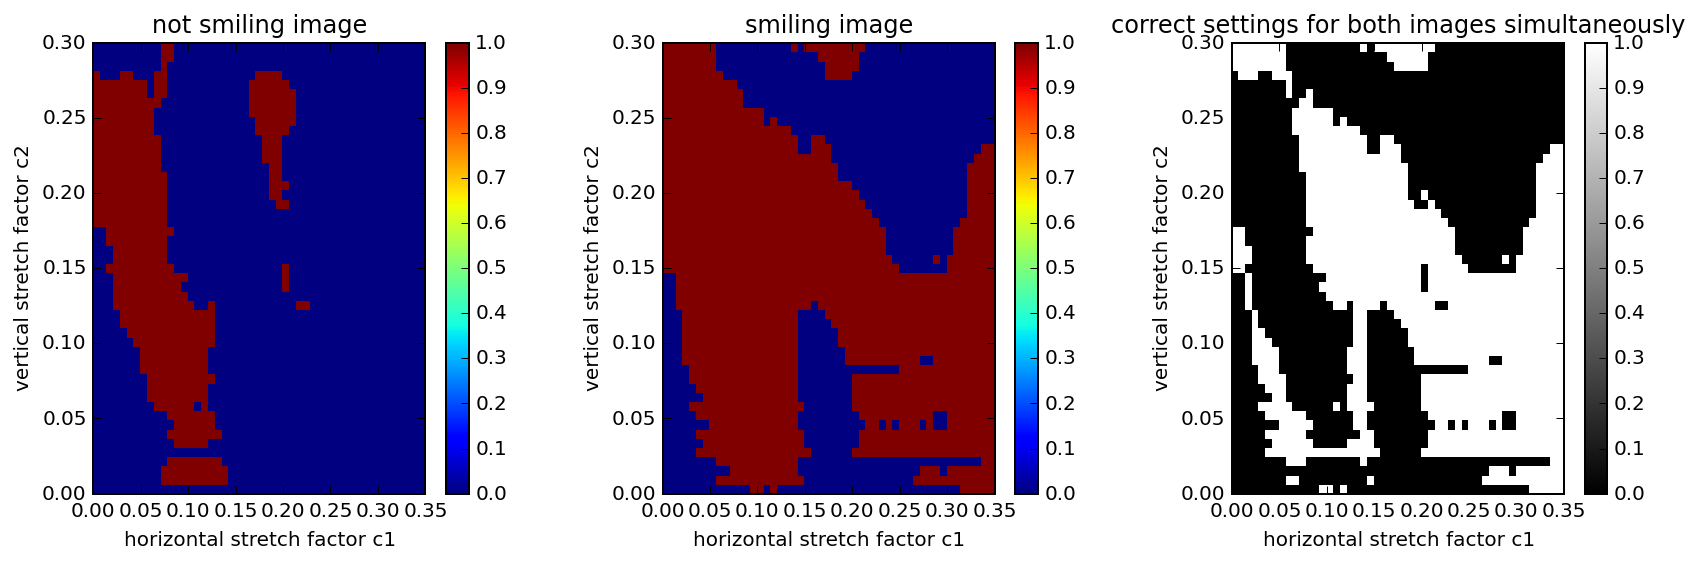

In [53]:
figure(figsize=(12, 4))
subplot(131)
title('not smiling image')
pcolormesh(r1[0], r1[1], r1[2])
colorbar()
xlabel('horizontal stretch factor c1')
ylabel('vertical stretch factor c2')

subplot(132)
title('smiling image')
pcolormesh(r2[0], r2[1], r2[2])
colorbar()
xlabel('horizontal stretch factor c1')
ylabel('vertical stretch factor c2')

subplot(133)
title('correct settings for both images simultaneously')
pcolormesh(r1[0], r1[1], (r1[2]==0) & (r2[2]==1), cmap='gray')
colorbar()
xlabel('horizontal stretch factor c1')
ylabel('vertical stretch factor c2')

tight_layout()

I decided to use the values `(0.03, 0.05)`, especially because they worked in the above interactive calibration tests. We will use these in the remainder of the post. As a sanity check, we can plot the average face extracted from our two calibration images.

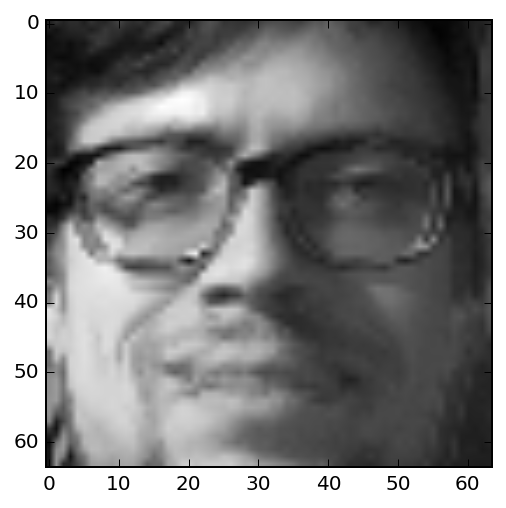

In [54]:
extracted_faces = []
for facefile in ["face5.jpg", "face6.jpg"]:
    gray, detected_faces = detect_face(cv2.imread(facefile))
    for face in detected_faces:
        extracted_face = extract_face_features(gray, face, offset_coefficients=(0.03, 0.05))
        extracted_faces.append(extracted_face)
        
imshow(mean(array(extracted_faces), axis=0), cmap='gray')

My mean face overlaps quite nicely. That's a good thing!

## Live detection using the webcam

Now that we have coded the face extraction routines and calibrated them in the previous section, we can move on to apply this to frames obtained from the webcam. My work was inspired by the following post: [https://realpython.com/blog/python/face-detection-in-python-using-a-webcam/](https://realpython.com/blog/python/face-detection-in-python-using-a-webcam/), from which the main loop was heavily inspired.
After detecting faces and predicting if they're smiling or not, we draw a rectangle around them, label them and display a miniature image of the extracted face to check that everything is going the way it should.

In [55]:
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    # detect faces
    gray, detected_faces = detect_face(frame)
    
    face_index = 0
    
    # predict output
    for face in detected_faces:
        (x, y, w, h) = face
        if w > 100:
            # draw rectangle around face 
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # extract features
            extracted_face = extract_face_features(gray, face, (0.03, 0.05)) #(0.075, 0.05)

            # predict smile
            prediction_result = predict_face_is_smiling(extracted_face)

            # draw extracted face in the top right corner
            frame[face_index * 64: (face_index + 1) * 64, -65:-1, :] = cv2.cvtColor(extracted_face * 255, cv2.COLOR_GRAY2RGB)

            # annotate main image with a label
            if prediction_result == 1:
                cv2.putText(frame, "SMILING",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            else:
                cv2.putText(frame, "not smiling",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)

            # increment counter
            face_index += 1
                

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

I recorded a short video showing the algorithm in practice for anyone interested. I admit that I selected a case where the algorithm works rather well. 

In [56]:
YouTubeVideo("mc3XGJaDEMc")

# Conclusions

I hope you have enjoyed reading this post as much as I have enjoyed writing it. I think there's a lot of things to be learned from this. My personal takeaways are:

- First, that machine learning doesn't need to be that difficult to use, thanks to awesome libraries like `scikit-learn`. It remains, however, difficult to understand how the underlying algorithms really work.
- Choosing parameters for the face extraction felt very arbitrary. Clearly, the algorithm doesn't work perfectly. I'd be really happy to have some feedback from knowledgeable people in this area.

This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20150107_SmileRecognition.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20150107_SmileRecognition.ipynb).